In [203]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
import random
from timm import create_model
import matplotlib.pyplot as plt
from einops import rearrange


In [204]:

class UperNetSwin(nn.Module):
    def __init__(self, num_classes=24):
        super(UperNetSwin, self).__init__()
        self.backbone = create_model('swin_tiny_patch4_window7_224', pretrained=True, features_only=True, img_size=384)
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        features = self.backbone(x)
        x = features[-1]  # Swin-T last feature
        if x.shape[1] < x.shape[-1]:  # Channel is last
            x = x.permute(0, 3, 1, 2)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x



In [205]:

class VDDatasetTiled(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, tile_size=384):
        self.images = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        self.tile_size = tile_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx]).convert("L")
        mask = np.array(mask)

        if image.size[0] > self.tile_size or image.size[1] > self.tile_size:
            image_tiles, mask_tiles = self.split_into_tiles(image, mask)
            idx_tile = random.randint(0, len(image_tiles) - 1)
            image, mask = image_tiles[idx_tile], mask_tiles[idx_tile]

        image = image.resize((self.tile_size, self.tile_size))
        mask = Image.fromarray(mask).resize((self.tile_size, self.tile_size), Image.NEAREST)
        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        return image, mask

    def split_into_tiles(self, image, mask):
        image_width, image_height = image.size
        image_tiles = []
        mask_tiles = []

        for i in range(0, image_width, self.tile_size):
            for j in range(0, image_height, self.tile_size):
                image_tile = image.crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                mask_tile = Image.fromarray(mask).crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                image_tiles.append(image_tile)
                mask_tiles.append(np.array(mask_tile))
        return image_tiles, mask_tiles


In [206]:

directory = {
    "train_images": "advanced_data/x_train",
    "train_masks": "advanced_data/y_train",
    "val_images": "advanced_data/x_valid",
    "val_masks": "advanced_data/y_valid",
    "test_images": "advanced_data/x_test",
    "test_masks": "advanced_data/y_test"
}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = VDDatasetTiled(directory["train_images"], directory["train_masks"], transform=transform)
val_dataset = VDDatasetTiled(directory["val_images"], directory["val_masks"], transform=transform)
test_dataset = VDDatasetTiled(directory["test_images"], directory["test_masks"], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


In [207]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UperNetSwin(num_classes=24).to(device)

weights = torch.tensor([0.5] + [2.0] * 23).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [208]:

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 2.3493
Epoch 2, Loss: 2.0245
Epoch 3, Loss: 2.0820
Epoch 4, Loss: 1.8815
Epoch 5, Loss: 1.8691
Epoch 6, Loss: 1.8279
Epoch 7, Loss: 1.7376
Epoch 8, Loss: 1.6685
Epoch 9, Loss: 1.7221
Epoch 10, Loss: 1.8377


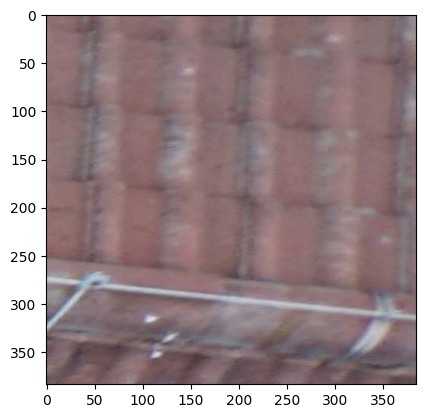

In [211]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
    return tensor * std + mean
image_disp = denormalize(images[i].cpu()).permute(1, 2, 0).numpy()
image_disp = np.clip(image_disp, 0, 1)
plt.imshow(image_disp)


Validation Loss: 1.5780, Accuracy: 0.5709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


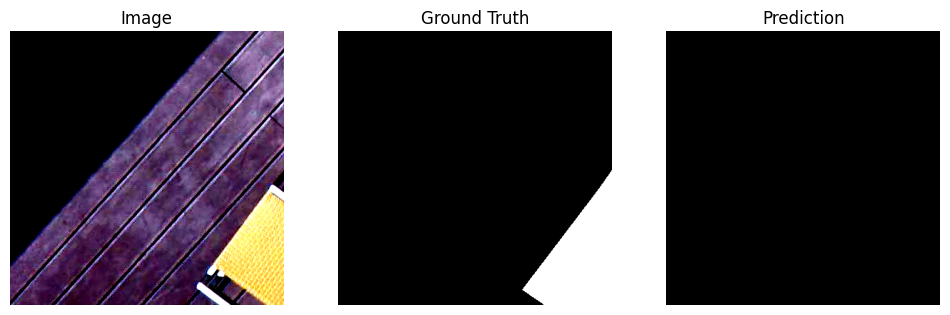

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4025275].


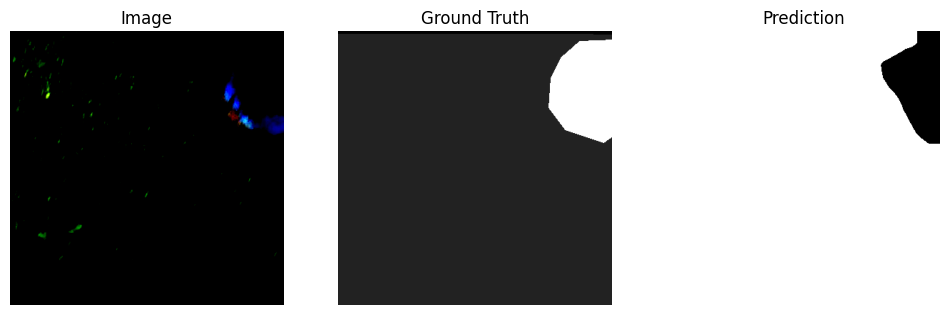

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1931673..1.8905448].


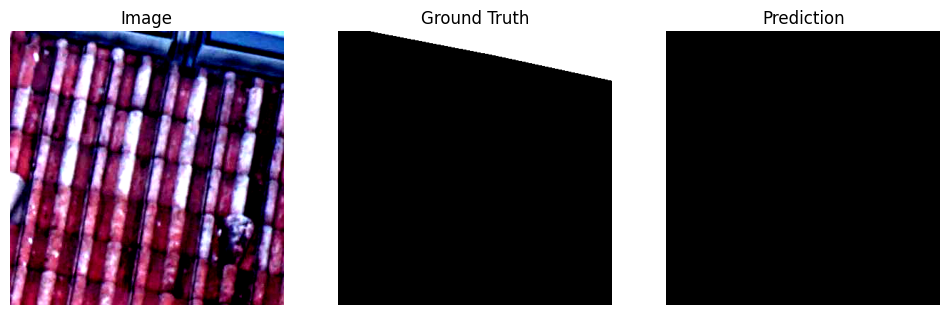

In [212]:

def calculate_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

model.eval()
val_loss = 0.0
val_acc = 0.0

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()
        val_acc += calculate_accuracy(outputs, masks).item()

print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_acc / len(val_loader):.4f}")

# Preview predictions
images, masks = next(iter(val_loader))
images = images.to(device)
outputs = model(images)
preds = torch.argmax(outputs, dim=1).cpu()

for i in range(min(3, images.shape[0])):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(images[i].cpu().permute(1, 2, 0).numpy())
    axs[0].set_title("Image")
    axs[1].imshow(masks[i].cpu(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(preds[i], cmap='gray')
    axs[2].set_title("Prediction")
    for ax in axs: ax.axis('off')
    plt.show()
